## Blood Cell Object Detection: Object Detection

Dataset Source: https://huggingface.co/datasets/keremberke/blood-cell-object-detection

#### Install Necessary Libraries

In [1]:
%pip install torch datasets tensorboard
%pip install transformers evaluate
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.5 MB/s eta 0:00:00


#### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Enter Huggingface Access Token

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


##### Import Necessary Libraries

In [4]:
import os, sys, random, shutil, re, json

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import PIL.Image

from tqdm import tqdm

import datasets
from datasets import load_dataset

import torch
import torchvision

import transformers
from transformers import AutoImageProcessor, TrainingArguments
from transformers import AutoModelForObjectDetection, Trainer

import albumentations

import evaluate

!git lfs install

Git LFS initialized.


##### Display Versions of Relevant Libraries

In [5]:
library_len = 14
version_len = 7

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|", "Library".rjust(library_len), "|", "Version".ljust(version_len), "|")
print(f"|{'*' * (library_len + version_len + 5)}|")
print("|", "Python".rjust(library_len), "|", sys.version[0:6].ljust(version_len), "|")
print("|", "NumPy".rjust(library_len), "|", np.__version__.ljust(version_len), "|")
print("|", "Torch".rjust(library_len), "|", torch.__version__.ljust(version_len), "|")
print("|", "Torch Vision".rjust(library_len), "|", torchvision.__version__.ljust(version_len), "|")
print("|", "Datasets".rjust(library_len), "|", datasets.__version__.ljust(version_len), "|")
print("|", "Albumentations".rjust(library_len), "|", albumentations.__version__.ljust(version_len), "|")
print("|", "Transformer".rjust(library_len), "|", transformers.__version__.ljust(version_len), "|")
print("|", "Evaluate".rjust(library_len), "|", evaluate.__version__.ljust(version_len), "|")
print(f"+{'-' * (library_len + version_len + 5)}+")

+--------------------------+
|        Library | Version |
|**************************|
|         Python | 3.10.1  |
|          NumPy | 1.22.4  |
|          Torch | 2.0.1+cu118 |
|   Torch Vision | 0.15.2+cu118 |
|       Datasets | 2.14.3  |
| Albumentations | 1.2.1   |
|    Transformer | 4.31.0  |
|       Evaluate | 0.4.0   |
+--------------------------+


#### Load Dataset

In [6]:
data = load_dataset("keremberke/blood-cell-object-detection", "full")

data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 255
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 73
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 36
    })
})

#### Display Features for Sample

In [7]:
data['train'][12]

{'image_id': 83,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=416x416>,
 'width': 416,
 'height': 416,
 'objects': {'id': [1104,
   1105,
   1106,
   1107,
   1108,
   1109,
   1110,
   1111,
   1112,
   1113,
   1114,
   1115,
   1116,
   1117,
   1118,
   1119],
  'area': [8186,
   5221,
   6188,
   6188,
   6188,
   7076,
   8147,
   7067,
   7339,
   4902,
   5076,
   5355,
   3534,
   3534,
   21824,
   1083],
  'bbox': [[120.0, 258.0, 88.5, 92.5],
   [199.0, 321.0, 59.0, 88.5],
   [310.0, 307.0, 68.0, 91.0],
   [245.0, 266.0, 68.0, 91.0],
   [255.0, 181.0, 68.0, 91.0],
   [196.0, 38.0, 76.5, 92.5],
   [120.0, 94.0, 76.5, 106.5],
   [243.0, 115.0, 74.0, 95.5],
   [115.0, 1.0, 78.5, 93.5],
   [34.0, 19.0, 86.0, 57.0],
   [344.0, 57.0, 71.5, 71.0],
   [353.0, 101.0, 63.0, 85.0],
   [326.0, 1.0, 62.0, 57.0],
   [243.0, 1.0, 62.0, 57.0],
   [1.0, 141.0, 124.0, 176.0],
   [105.0, 278.0, 28.5, 38.0]],
  'category': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0]}}

#### Define List of Category Names & Conversion Dictionaries

In [8]:
categories = data["train"].features["objects"].feature["category"].names

NUM_OF_CATEGORIES = len(categories)

id2label = {idx: tag for idx, tag in enumerate(categories)}
label2id = {tag: idx for idx, tag in enumerate(categories)}

print(f"List of Category Names:\n{categories}")
print(f"Number of Category Names: {NUM_OF_CATEGORIES}")
print(f"id2label:\n{id2label}")
print(f"label2id:\n{label2id}")

List of Category Names:
['platelets', 'rbc', 'wbc']
Number of Category Names: 3
id2label:
{0: 'platelets', 1: 'rbc', 2: 'wbc'}
label2id:
{'platelets': 0, 'rbc': 1, 'wbc': 2}


#### Visualize A Sample

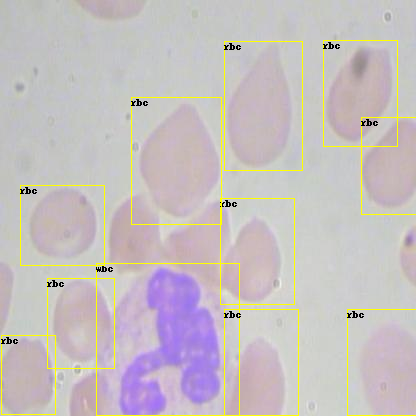

In [9]:
sample = data['train'][24]

sample_image = sample['image']
annotations = sample['objects']

draw = ImageDraw.Draw(sample_image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=1)
    draw.text((x, y), id2label[class_idx], fill="black")

sample_image

#### Basic Values/Constants

In [10]:
MODEL_CKPT = "hustvl/yolos-small"
MODEL_NAME = f'{MODEL_CKPT.split("/")[-1]}-Blood_Cell_Object_Detection'

LR = 1e-5
WEIGHT_DECAY = 1e-4

NUM_OF_EPOCHS = 25
BATCH_SIZE = 8

STRATEGY = "steps"
REPORTS_TO = "tensorboard"

#### Instantiate Image Processor

In [11]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


#### Define Some Transformations for Images

In [12]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=['category']),
)

#### Create Function to Reformat Annotations Correctly

In [13]:
def reformat_annotations(image_id, category, area, bbox):
    annotations = []
    for x in range(0, len(category)):
        new_annotation = {
            "image_id": image_id,
            "category_id": category[x],
            "isCrowd": 0,
            "area": area[x],
            "bbox": list(bbox[x]),
        }
        annotations.append(new_annotation)

    return annotations

#### Combine Image & Annotation Transformations For Use On Batch of Samples

In [14]:
def transform_image_ann(samples):
    image_ids = samples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(samples["image"], samples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        { "image_id": id_, "annotations": reformat_annotations(id_, cat_, ar_, box_)
        } for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images,
                           annotations=targets,
                           return_tensors="pt")

#### Apply Image Transformations to Training Dataset

In [15]:
data['train'] = data['train'].with_transform(transform_image_ann)

data['train'][24]

{'pixel_values': tensor([[[1.4783, 1.4783, 1.4954,  ..., 0.9988, 0.9988, 0.9988],
          [1.4783, 1.4783, 1.4954,  ..., 0.9988, 0.9988, 0.9988],
          [1.4783, 1.4783, 1.4954,  ..., 0.9988, 0.9988, 0.9988],
          ...,
          [1.4954, 1.4954, 1.4954,  ..., 1.3755, 1.3927, 1.3927],
          [1.4954, 1.4954, 1.4954,  ..., 1.3755, 1.3927, 1.3927],
          [1.4954, 1.4954, 1.4954,  ..., 1.3755, 1.3927, 1.3927]],
 
         [[1.5532, 1.5532, 1.5707,  ..., 1.4307, 1.4307, 1.4307],
          [1.5532, 1.5532, 1.5707,  ..., 1.4307, 1.4307, 1.4307],
          [1.5532, 1.5532, 1.5707,  ..., 1.4307, 1.4307, 1.4307],
          ...,
          [1.3431, 1.3431, 1.3431,  ..., 1.6232, 1.6057, 1.6057],
          [1.3431, 1.3431, 1.3431,  ..., 1.6232, 1.6057, 1.6057],
          [1.3431, 1.3431, 1.3431,  ..., 1.6232, 1.6057, 1.6057]],
 
         [[1.7860, 1.7860, 1.8034,  ..., 1.5594, 1.5594, 1.5594],
          [1.7860, 1.7860, 1.8034,  ..., 1.5594, 1.5594, 1.5594],
          [1.7860, 1.786

#### Define Data Collator

In [16]:
def data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

#### Define Model

In [17]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define TrainingArguments

In [18]:
args = TrainingArguments(
    MODEL_NAME,
    auto_find_batch_size=True,
    num_train_epochs=NUM_OF_EPOCHS,
    logging_first_step=True,
    logging_strategy=STRATEGY,
    logging_steps=100,
    save_strategy=STRATEGY,
    save_steps=871,
    save_total_limit=12,
    remove_unused_columns=False,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    fp16=True,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [19]:
trainer = Trainer(
    model,
    args=args,
    data_collator=data_collator_fn,
    train_dataset=data['train'],
    tokenizer=image_processor,
)

Cloning https://huggingface.co/DunnBC22/yolos-small-Blood_Cell_Object_Detection into local empty directory.


#### Train Model

In [20]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,3.614300
100,1.551300
200,1.057500
300,0.943600
400,0.921600
500,0.863800
600,0.852100
700,0.792300
800,0.822000
900,0.802900


TrainOutput(global_step=3200, training_loss=0.6826970759034157, metrics={'train_runtime': 3603.81, 'train_samples_per_second': 1.769, 'train_steps_per_second': 0.888, 'total_flos': 2.25100121472e+18, 'train_loss': 0.6826970759034157, 'epoch': 25.0})

#### Push Model To Hub

In [21]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/117M [00:00<?, ?B/s]

Upload file runs/Aug05_18-19-15_1b1c2871f99f/events.out.tfevents.1691259572.1b1c2871f99f.214.0:   0%|         …

To https://huggingface.co/DunnBC22/yolos-small-Blood_Cell_Object_Detection
   da9ab82..ac351ec  main -> main

   da9ab82..ac351ec  main -> main

To https://huggingface.co/DunnBC22/yolos-small-Blood_Cell_Object_Detection
   ac351ec..6064483  main -> main

   ac351ec..6064483  main -> main



'https://huggingface.co/DunnBC22/yolos-small-Blood_Cell_Object_Detection/commit/ac351ecbce6e79961f67c3afcd3f3c3af94faaf1'

#### Save Model

In [22]:
trainer.save_model()
trainer.save_state()

### Evaluate Model

#### Create Function to Reformat Evaluation Annotations Correctly

In [28]:
def eval_formatted_annotations(image_id, objects):
    annotations = []

    for x in range(0, len(objects["id"])):
        new_annotation = {
            "id": objects["id"][x],
            "category_id": objects["category"][x],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][x],
            "bbox": objects["bbox"][x],
        }
        annotations.append(new_annotation)

    return annotations

#### Define Data Collator

In [29]:
def eval_data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

#### Save Images & Annotations into Proper Files

In [30]:
"""
Save images & annotations in format that
torchvision.datasets.CocoDetection expects
"""

def save_images_and_annotation_files(ds):
    output_json = {}
    path_output_ds = "/content/drive/MyDrive/projects/Blood Cells/data"

    if not os.path.exists(path_output_ds):
        os.makedirs(path_output_ds)

    path_annotation = os.path.join(path_output_ds, "blood_cells.json")
    categories_json = [
        {"supercategory" : "none", "id": id, "name": id2label[id]}
        for id in id2label]
    output_json['images'] = []
    output_json['annotations'] = []

    for sample in ds:
        anno = eval_formatted_annotations(sample["image_id"], sample["objects"])
        output_json["images"].append(
            {
                "id": sample["image_id"],
                "width": sample["image"].width,
                "height": sample["image"].height,
                "file_name": f"{sample['image_id']}.png",
            }
        )
        output_json["annotations"].extend(anno)
    output_json["categories"] = categories_json

    with open(path_annotation, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(ds["image"], ds["image_id"]):
        path_image = os.path.join(path_output_ds, f"{img_id}.png")
        im.save(path_image)

    return path_output_ds, path_annotation

#### Create Class to Ingest Datasets

In [31]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, annot_file):
        super().__init__(img_folder, annot_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image & target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img,
                                          annotations=target,
                                          return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

#### Apply Above-Defined Functions to Validation Dataset

In [32]:
EVAL_MODEL_NAME = f'DunnBC22/yolos-small-Blood_Cell_Object_Detection'

eval_image_processor = AutoImageProcessor.from_pretrained(EVAL_MODEL_NAME)

path_output_ds, path_annot = save_images_and_annotation_files(data["validation"])
eval_ds_coco_format = CocoDetection(path_output_ds,
                                    eval_image_processor,
                                    path_annot)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


#### Calculate Metrics

In [33]:
model = AutoModelForObjectDetection.from_pretrained(EVAL_MODEL_NAME)

module = evaluate.load("ybelkada/cocoevaluate",
                       coco=eval_ds_coco_format.coco)

eval_dataloader = torch.utils.data.DataLoader(
    eval_ds_coco_format,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=eval_data_collator_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(eval_dataloader)):
        pixel_values = batch["pixel_values"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]

        # forward pass
        outputs = model(pixel_values=pixel_values)

        orig_target_sizes = torch.stack(
            [
                target["orig_size"] for target in labels
            ],
            dim=0)

        results = eval_image_processor.post_process(outputs,
                                                    orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 10/10 [11:18<00:00, 67.85s/it]


Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

#### Display Metrics

In [34]:
print(results)

{'iou_bbox': {'AP-IoU=0.50:0.95-area=all-maxDets=100': 0.344394504597831, 'AP-IoU=0.50-area=all-maxDets=100': 0.5794578345922996, 'AP-IoU=0.75-area=all-maxDets=100': 0.37384070353080256, 'AP-IoU=0.50:0.95-area=small-maxDets=100': 0.09740658803743132, 'AP-IoU=0.50:0.95-area=medium-maxDets=100': 0.25826573668733366, 'AP-IoU=0.50:0.95-area=large-maxDets=100': 0.2238568057771438, 'AR-IoU=0.50:0.95-area=all-maxDets=1': 0.20992438360859417, 'AR-IoU=0.50:0.95-area=all-maxDets=10': 0.3760490971017287, 'AR-IoU=0.50:0.95-area=all-maxDets=100': 0.4482102692629008, 'AR-IoU=0.50:0.95-area=small-maxDets=100': 0.10784313725490198, 'AR-IoU=0.50:0.95-area=medium-maxDets=100': 0.37522550225502255, 'AR-IoU=0.50:0.95-area=large-maxDets=100': 0.4478494623655914}}


### Notes & Other Takeaways
****
- Overall, the results are okay but not stellar.

****

### Citations

- Model Checkpoint (YOLOS-Small)

    > @article{DBLP:journals/corr/abs-2106-00666, author = {Yuxin Fang and Bencheng Liao and Xinggang Wang and Jiemin Fang and Jiyang Qi and Rui Wu and Jianwei Niu and Wenyu Liu}, title  = {You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection}, journal = {CoRR}, volume = {abs/2106.00666}, year = {2021}, url = {https://arxiv.org/abs/2106.00666}, eprinttype = {arXiv}, eprint = {2106.00666}, timestamp = {Fri, 29 Apr 2022 19:49:16 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2106-00666.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}


- Dataset

    > @inproceedings{inproceedings, author = {N J Karthika, Chandran Saravanan}, booktitle = {International Conference on Electronic Systems and Intelligent Computing (ESIC 2020)}, year = {2020}, month = {3), title = {Addressing False Positives in Pedestrian Detection}, doi = {https://doi.org/10.1007/978-981-15-7031-5_103}}